In [13]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2
from torchsummary import summary
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 0. Define Functions and Models

In [2]:
def modify_img_path(path):
    new_path = 'data/' + path.split('/Users/anthonywang/Deep_Learning/')[1]
    return new_path


class ScrambledImageDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # get ingredients for retrieving image
        path = row['img_path']
        
        # read the img
        img = cv2.imread(path)
        
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # move color channels to correct spot
        img = np.transpose(img, (2, 0, 1))
        
        # convert to [0,1] scale
        img = torch.tensor(img / 255.).float()
        
        numeric_feature = torch.tensor([row['r'], row['discolor_ratio']]).float()
        
        label = torch.tensor([row['x']/800, row['y']/800]).float()
        
        return img, numeric_feature, label

    
# Vanilla CNN using only the images
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # same padding!
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.linear1 = nn.Linear(160000,100)
        self.linear2 = nn.Linear(100, 2)
        
        # pooling
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # activation
        self.relu = nn.ReLU()
        
        # for unrolling into FC layer
        self.unroll = nn.Flatten()
        
    def forward(self, x, numeric):       
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        x = self.pool(x)
        x = self.relu(x)
        
        x = self.conv5(x)
        x = self.relu(x)
        # unroll x for FC layer
        x = self.linear1(self.unroll(x))
        x = self.relu(x)
        x = self.linear2(x)
        
        return x


# CNN combine with numeric features before FC layer
class CNNNumericCat(nn.Module):
    def __init__(self):
        super().__init__()
        
        # same padding!
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.linear1 = nn.Linear(160002,100)
        self.linear2 = nn.Linear(100, 2)
        
        # pooling
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # activation
        self.relu = nn.ReLU()
        
        # for unrolling into FC layer
        self.unroll = nn.Flatten()
        
    def forward(self, x, numeric):       
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        x = self.pool(x)
        x = self.relu(x)
        
        x = self.conv5(x)
        x = self.relu(x)
        
        # unroll x for FC layer
        x = self.unroll(x)
        # concate image with numberic feature
        x = torch.cat((x, numeric), 1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        
        return x


# CNN combine with numeric features after FC layer
class CNNLinearNumericCat(nn.Module):
    def __init__(self):
        super().__init__()
        
        # same padding!
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.linear1 = nn.Linear(160000,100)
        self.linear2 = nn.Linear(102, 2)
        
        # pooling
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # activation
        self.relu = nn.ReLU()
        
        # for unrolling into FC layer
        self.unroll = nn.Flatten()
        
    def forward(self, x, numeric):       
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        x = self.pool(x)
        x = self.relu(x)
        
        x = self.conv5(x)
        x = self.relu(x)
        
        # unroll x for FC layer
        x = self.unroll(x)
        x = self.linear1(x)
        x = self.relu(x)
        # concate image with numberic feature after passing x through a linear layer
        x = torch.cat((x, numeric), 1)
        x = self.linear2(x)
        
        return x
    

# CNN combine with numeric feature passed through a linear layer before FC layer
class CNNLinearNumericLinearCat(nn.Module):
    def __init__(self):
        super().__init__()
        
        # same padding!
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.linear0 = nn.Linear(2,2)
        self.linear1 = nn.Linear(160002,100)
        self.linear2 = nn.Linear(100, 2)
        
        # pooling
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # activation
        self.relu = nn.ReLU()
        
        # for unrolling into FC layer
        self.unroll = nn.Flatten()
        
    def forward(self, x, numeric):       
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv4(x)
        x = self.pool(x)
        x = self.relu(x)
        
        x = self.conv5(x)
        x = self.relu(x)
        
        # unroll x for FC layer
        x = self.unroll(x)
        # pass numeric to a linear layer before concate with image
        numeric = self.linear0(numeric)
        # concate image with numberic feature
        x = torch.cat((x, numeric), 1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        
        return x
    

def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    total_distance = 0.0
    for x, numeric, y in dataloader:
        
        y_pred = model(x, numeric)
        loss = lossFun(y_pred, y)
        distance = torch.cdist(y, y_pred, p=2).diagonal().mean()
        total_loss += loss.item()
        total_distance += distance.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    avg_distance = total_distance / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss, avg_distance


def train_model(lossFun, model, lr=5e-4, num_epochs=10):
    optimizer = optim.Adam(model.parameters(), lr = lr)
    train_losses = []
    train_distances = []
    valid_losses = []
    vaild_distances = []
    
    for epoch in range(num_epochs):

        train_loss, train_distance = one_pass(model, dl_train, optimizer, lossFun)
        train_losses.append(train_loss)
        train_distances.append(train_distance)

        valid_loss, valid_distance = one_pass(model, dl_val, optimizer, lossFun, backwards=False)
        valid_losses.append(valid_loss)
        vaild_distances.append(valid_distance)

        print('Epoch:', epoch+1, 'Train Loss:', round(train_loss, 4), 'Train Distance:', round(train_distance, 4),
              'Valid Loss:', round(valid_loss, 4), 'Valid Distance:', round(valid_distance, 4))
    
    return train_losses, train_distances, valid_losses, vaild_distances

## 1. Import Data

In [3]:
df = pd.read_csv('data/scrambled_imgs_df.csv')
df.head()

,x,y,r,discolor_ratio,img_path
0,599,120,89,1.08,/Users/anthonywang/Deep_Learning/landscape_scr...
1,376,646,30,1.08,/Users/anthonywang/Deep_Learning/landscape_scr...
2,246,281,30,1.10,/Users/anthonywang/Deep_Learning/landscape_scr...
3,480,360,174,1.08,/Users/anthonywang/Deep_Learning/landscape_scr...
4,223,430,111,1.14,/Users/anthonywang/Deep_Learning/landscape_scr...


In [4]:
df['img_path'] = df['img_path'].apply(lambda x: modify_img_path(x))
df.head()

,x,y,r,discolor_ratio,img_path
0,599,120,89,1.08,data/landscape_scrambled/0.jpg
1,376,646,30,1.08,data/landscape_scrambled/1.jpg
2,246,281,30,1.10,data/landscape_scrambled/2.jpg
3,480,360,174,1.08,data/landscape_scrambled/3.jpg
4,223,430,111,1.14,data/landscape_scrambled/4.jpg


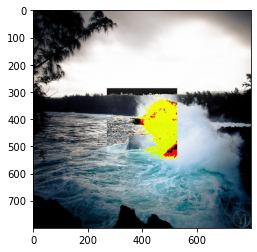

In [5]:
# show an example image
row = df.iloc[11]
image_path = row['img_path']
img = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
# train, test data split
df_train, df_val = train_test_split(df, test_size=0.2, random_state = 42)
len(df_train), len(df_val)

(160, 40)

In [7]:
# prepare dataloaders for train and validation
ds_train = ScrambledImageDataset(df_train)
dl_train = DataLoader(ds_train, batch_size = 10, shuffle=True)

ds_val = ScrambledImageDataset(df_val)
dl_val = DataLoader(ds_val, batch_size = len(ds_val))

next(iter(ds_train))[0].shape, next(iter(ds_val))[0].shape

(torch.Size([3, 800, 800]), torch.Size([3, 800, 800]))

## 2. Train Different Models

In [8]:
# CNN trained with only images data with higher learning rate and fewer epochs
lossFun = nn.MSELoss()
model1 = CNN()
lr = 5e-4
num_epochs = 10
train_losses1, train_distances1, valid_losses1, vaild_distances1 = train_model(
    lossFun, model1, lr=lr, num_epochs=num_epochs)

Epoch: 1 Train Loss: 0.0835 Train Distance: 0.3545 Valid Loss: 0.0748 Valid Distance: 0.3631
Epoch: 2 Train Loss: 0.051 Train Distance: 0.2927 Valid Loss: 0.0568 Valid Distance: 0.3166
Epoch: 3 Train Loss: 0.0475 Train Distance: 0.2858 Valid Loss: 0.0564 Valid Distance: 0.317
Epoch: 4 Train Loss: 0.0482 Train Distance: 0.283 Valid Loss: 0.0738 Valid Distance: 0.3574
Epoch: 5 Train Loss: 0.0487 Train Distance: 0.2857 Valid Loss: 0.0655 Valid Distance: 0.3408
Epoch: 6 Train Loss: 0.0474 Train Distance: 0.2819 Valid Loss: 0.0622 Valid Distance: 0.3331
Epoch: 7 Train Loss: 0.0455 Train Distance: 0.2776 Valid Loss: 0.0595 Valid Distance: 0.3249
Epoch: 8 Train Loss: 0.0457 Train Distance: 0.2798 Valid Loss: 0.0691 Valid Distance: 0.3499
Epoch: 9 Train Loss: 0.0494 Train Distance: 0.2895 Valid Loss: 0.057 Valid Distance: 0.3101
Epoch: 10 Train Loss: 0.0492 Train Distance: 0.2881 Valid Loss: 0.053 Valid Distance: 0.2984


In [9]:
# CNN trained with only images data with lower learning rate and more epochs
lossFun = nn.MSELoss()
model2 = CNN()
lr = 1e-4
num_epochs = 30
train_losses2, train_distances2, valid_losses2, vaild_distances2 = train_model(
    lossFun, model2, lr=lr, num_epochs=num_epochs)

Epoch: 1 Train Loss: 0.0645 Train Distance: 0.3218 Valid Loss: 0.0575 Valid Distance: 0.3049
Epoch: 2 Train Loss: 0.0541 Train Distance: 0.3061 Valid Loss: 0.0522 Valid Distance: 0.3002
Epoch: 3 Train Loss: 0.049 Train Distance: 0.2869 Valid Loss: 0.0672 Valid Distance: 0.345
Epoch: 4 Train Loss: 0.0441 Train Distance: 0.2754 Valid Loss: 0.0585 Valid Distance: 0.3226
Epoch: 5 Train Loss: 0.0419 Train Distance: 0.2657 Valid Loss: 0.054 Valid Distance: 0.3102
Epoch: 6 Train Loss: 0.0428 Train Distance: 0.2637 Valid Loss: 0.0548 Valid Distance: 0.3093
Epoch: 7 Train Loss: 0.0432 Train Distance: 0.269 Valid Loss: 0.0526 Valid Distance: 0.302
Epoch: 8 Train Loss: 0.0382 Train Distance: 0.2499 Valid Loss: 0.0643 Valid Distance: 0.3309
Epoch: 9 Train Loss: 0.0347 Train Distance: 0.2398 Valid Loss: 0.0505 Valid Distance: 0.2962
Epoch: 10 Train Loss: 0.0317 Train Distance: 0.2271 Valid Loss: 0.0712 Valid Distance: 0.3464
Epoch: 11 Train Loss: 0.0303 Train Distance: 0.2217 Valid Loss: 0.0562 Val

In [10]:
# CNN trained images and numeric features combined before the fully connected layers
lossFun = nn.MSELoss()
model3 = CNNNumericCat()
lr = 5e-4
num_epochs = 20
train_losses3, train_distances3, valid_losses3, vaild_distances3 = train_model(
    lossFun, model3, lr=lr, num_epochs=num_epochs)

Epoch: 1 Train Loss: 0.1193 Train Distance: 0.4419 Valid Loss: 0.0545 Valid Distance: 0.3096
Epoch: 2 Train Loss: 0.0561 Train Distance: 0.3007 Valid Loss: 0.0612 Valid Distance: 0.3292
Epoch: 3 Train Loss: 0.0507 Train Distance: 0.2907 Valid Loss: 0.0574 Valid Distance: 0.3174
Epoch: 4 Train Loss: 0.0499 Train Distance: 0.2916 Valid Loss: 0.0553 Valid Distance: 0.3095
Epoch: 5 Train Loss: 0.0461 Train Distance: 0.2801 Valid Loss: 0.0544 Valid Distance: 0.3075
Epoch: 6 Train Loss: 0.045 Train Distance: 0.2765 Valid Loss: 0.063 Valid Distance: 0.3341
Epoch: 7 Train Loss: 0.0448 Train Distance: 0.273 Valid Loss: 0.055 Valid Distance: 0.3082
Epoch: 8 Train Loss: 0.0427 Train Distance: 0.2697 Valid Loss: 0.0575 Valid Distance: 0.315
Epoch: 9 Train Loss: 0.0383 Train Distance: 0.2531 Valid Loss: 0.0657 Valid Distance: 0.3388
Epoch: 10 Train Loss: 0.0331 Train Distance: 0.2312 Valid Loss: 0.0648 Valid Distance: 0.3316
Epoch: 11 Train Loss: 0.0306 Train Distance: 0.222 Valid Loss: 0.0705 Vali

In [11]:
# CNN trained images and numeric features combined before the last fully connected layers
lossFun = nn.MSELoss()
model4 = CNNLinearNumericCat()
lr = 1e-3
num_epochs = 30
train_losses4, train_distances4, valid_losses4, vaild_distances4 = train_model(
    lossFun, model4, lr=lr, num_epochs=num_epochs)

Epoch: 1 Train Loss: 25.3081 Train Distance: 5.7565 Valid Loss: 17.5234 Valid Distance: 5.0055
Epoch: 2 Train Loss: 12.956 Train Distance: 4.3608 Valid Loss: 11.4713 Valid Distance: 3.6199
Epoch: 3 Train Loss: 9.256 Train Distance: 3.6448 Valid Loss: 8.6798 Valid Distance: 3.2297
Epoch: 4 Train Loss: 6.8777 Train Distance: 3.0927 Valid Loss: 6.7966 Valid Distance: 2.8544
Epoch: 5 Train Loss: 4.3653 Train Distance: 2.4779 Valid Loss: 5.6721 Valid Distance: 2.8132
Epoch: 6 Train Loss: 2.8259 Train Distance: 2.043 Valid Loss: 3.672 Valid Distance: 2.0097
Epoch: 7 Train Loss: 2.1252 Train Distance: 1.7083 Valid Loss: 3.295 Valid Distance: 1.8651
Epoch: 8 Train Loss: 1.8551 Train Distance: 1.6345 Valid Loss: 1.8546 Valid Distance: 1.4891
Epoch: 9 Train Loss: 1.0988 Train Distance: 1.2411 Valid Loss: 1.4245 Valid Distance: 1.3258
Epoch: 10 Train Loss: 0.7238 Train Distance: 1.0115 Valid Loss: 1.1659 Valid Distance: 1.138
Epoch: 11 Train Loss: 0.5359 Train Distance: 0.875 Valid Loss: 0.8646 V

In [12]:
# CNN trained images and numeric features passing through a linear layer first then combined before the last fully connected layers
lossFun = nn.MSELoss()
model5 = CNNLinearNumericLinearCat()
lr = 1e-3
num_epochs = 30
train_losses5, train_distances5, valid_losses5, vaild_distances5 = train_model(
    lossFun, model2, lr=lr, num_epochs=num_epochs)

Epoch: 1 Train Loss: 0.9994 Train Distance: 0.8559 Valid Loss: 0.1903 Valid Distance: 0.5757
Epoch: 2 Train Loss: 0.0731 Train Distance: 0.344 Valid Loss: 0.0615 Valid Distance: 0.3294
Epoch: 3 Train Loss: 0.0454 Train Distance: 0.2783 Valid Loss: 0.0565 Valid Distance: 0.3125
Epoch: 4 Train Loss: 0.0446 Train Distance: 0.2762 Valid Loss: 0.0659 Valid Distance: 0.3426
Epoch: 5 Train Loss: 0.0459 Train Distance: 0.2817 Valid Loss: 0.0612 Valid Distance: 0.3308
Epoch: 6 Train Loss: 0.044 Train Distance: 0.274 Valid Loss: 0.0538 Valid Distance: 0.3102
Epoch: 7 Train Loss: 0.0431 Train Distance: 0.2723 Valid Loss: 0.0606 Valid Distance: 0.3287
Epoch: 8 Train Loss: 0.0442 Train Distance: 0.2759 Valid Loss: 0.0576 Valid Distance: 0.3207
Epoch: 9 Train Loss: 0.042 Train Distance: 0.267 Valid Loss: 0.0526 Valid Distance: 0.3054
Epoch: 10 Train Loss: 0.041 Train Distance: 0.264 Valid Loss: 0.0536 Valid Distance: 0.3084
Epoch: 11 Train Loss: 0.0397 Train Distance: 0.2586 Valid Loss: 0.0562 Valid

## 3. Comparing Models

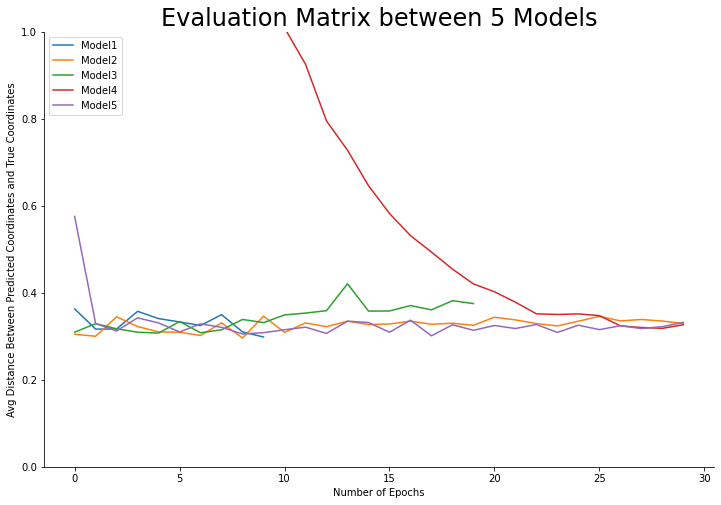

In [32]:
fig, ax = plt.subplots(figsize=(12, 8), sharex=True)
ax.set_ylim([0, 1])
ax.plot(vaild_distances1, label='Model1')
ax.plot(vaild_distances2, label='Model2')
ax.plot(vaild_distances3, label='Model3')
ax.plot(vaild_distances4, label='Model4')
ax.plot(vaild_distances5, label='Model5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Avg Distance Between Predicted Coordinates and True Coordinates')
ax.set_xlabel('Number of Epochs')
ax.legend(loc='upper left')
ax.set_title('Evaluation Matrix between 5 Models', fontdict={'fontsize': 24})
plt.show()